In [1]:
import csv
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, \
    GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

raw_train_df = pd.read_csv('Data/fake_or_real_news_training.csv')
raw_test_df = pd.read_csv('Data/fake_or_real_news_test.csv')

raw_train_df.head()


,ID,title,text,label,X1,X2
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN


In [2]:
raw_train_df.shape

(3999, 6)

In [3]:
raw_test_df.shape

(2321, 3)

In [4]:
raw_test_df.head()

,ID,title,text
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...


In [5]:
prepared_train_df = raw_train_df.copy()
prepared_test_df = raw_test_df.copy()

In [6]:
prepared_test_df['label'] = None
prepared_test_df.head()

,ID,title,text,label
0,10498,September New Homes Sales Rise——-Back To 1992 ...,September New Homes Sales Rise Back To 1992 Le...,None
1,2439,Why The Obamacare Doomsday Cult Can't Admit It...,But when Congress debated and passed the Patie...,None
2,864,"Sanders, Cruz resist pressure after NY losses,...",The Bernie Sanders and Ted Cruz campaigns vowe...,None
3,4128,Surviving escaped prisoner likely fatigued and...,Police searching for the second of two escaped...,None
4,662,Clinton and Sanders neck and neck in Californi...,No matter who wins California's 475 delegates ...,None


# Baseline Modeling

In [16]:
def score_model(df, model, vectorizer, target_var, independent_var,
                size, seed, standalone=False, return_model=True):
    df_new = df.copy()

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=seed)

    #Toggle if pipeline or discrete model is passed
    if(standalone):
        pipeline = model.fit(X=X_train, y=y_train)
    else:
        pipeline = make_pipeline(vectorizer, model).fit(X=X_train, y=y_train)

    pred = pipeline.predict(X_test)

    #Toggle to include model in output
    if(return_model):
        return(pipeline.score(X_test, y_test), y_test, pred, pipeline)
    else:
        return(pipeline.score(X_test, y_test), y_test, pred)


def cv_evaluate(df, model, vectorizer, target_var, independent_var, seed, cv=5,
                standalone=False, metric='accuracy'):
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]

    #Toggle if pipeline or discrete model is passed
    if(standalone):
        benchmark_model = make_pipeline(
            vectorizer, model).fit(X=X, y=y.values.ravel())
    else:
        benchmark_model = make_pipeline(model).fit(X=X, y=y.values.ravel())

    scores = cross_val_score(benchmark_model, X, y.values.ravel(),
                             scoring=metric, cv=kfolds)
    return scores[scores >= 0.0]


def tune_model(df, model, vectorizer, param, target_var, independent_var,
               seed, cv=5, n_jobs=-1, gridSearch=False, verbose=True, metric='accuracy'):
    df_new = df.copy()
    kfolds = KFold(n_splits=cv, shuffle=True, random_state=seed)

    X = df_new.loc[:, independent_var]
    y = df_new.loc[:, target_var]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=size, random_state=seed)
    pipeline = Pipeline([vectorizer, model])

    #Toggle to run Grid Search or Randomized Search (to save on computation time)
    if(gridSearch):
        gsearch = GridSearchCV(estimator=pipeline, param_grid=param,
                               scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)
    else:
        gsearch = RandomizedSearchCV(estimator=pipeline, param_distributions=param,
                                     scoring=metric, n_jobs=n_jobs, cv=kfolds, verbose=verbose)

    gsearch.fit(X_train, y_train)
    tuned_model = gsearch.best_estimator_

    if(verbose):
        print('='*20)
        print("best params: " + str(gsearch.best_estimator_))
        print("best params: " + str(gsearch.best_params_))
        print('best score:', gsearch.best_score_)
        print('='*20)

    return tuned_model


def confusion_heat_map(test_set, prediction_set, class_names):
    cm = confusion_matrix(test_set, prediction_set, class_names)
    fig, ax = plt.subplots()

    # create heatmap
    g = sns.heatmap(cm, annot=True, cmap="YlGnBu", fmt='g',
                    xticklabels=True, yticklabels=True)
    ax.xaxis.set_label_position("top")
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    plt.title('Confusion matrix', y=1.1)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def run_full_iteration(df, model, vectorizer, target_var, independent_var, size,
                       seed, standalone=False, return_model=True, cv=5):
    #Returns score on holdout set
    score, y_test, pred, model = score_model(
        df, model, vectorizer, target_var, independent_var, size,
        seed, standalone, return_model)
    print("Accuracy: %0.3f" % score)

    #Returns cross-validated score
    accuracy = cv_evaluate(df, model, vectorizer,
                           target_var, independent_var, seed, cv)
    print('Mean Accuracy after CV: {:.3f} +/- {:.03f}'.format(np.mean(accuracy), np.std(accuracy)))
    print('Best Accuracy after CV: {:.3f}'.format(max(accuracy)))

    confusion_heat_map(y_test, pred, ['FAKE', 'REAL'])


def csv_conversion(df, y, id_field, old_target_name):
    # Merge prediction with original data set to map with id
    raw_output = df.join(y)
    clean_output = raw_output.loc[:, [id_field, 0]]
    clean_output.columns = [id_field, old_target_name]
    return clean_output


## Tfid Vectorizer

In [8]:
# Set test set size, seed and target metric for the rest of the pipeline
size = 0.20
seed = 12345
target_var = 'label'
independent_var = 'text'

models = []
models.append(('MNB', MultinomialNB()))
models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto')))
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state=seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

vectorizer = TfidfVectorizer(stop_words='english')

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.809707 (0.026723)
LR: 0.906729 (0.005771)
RFC: 0.831965 (0.016928)
SVM: 0.916733 (0.008318)
PAC: 0.918731 (0.005694)


## Count Vectorizer

In [9]:
vectorizer = CountVectorizer(stop_words='english')

models = []
models.append(('MNB', MultinomialNB()))
# models.append(('LR', LogisticRegression(solver='lbfgs', multi_class='auto'))) #Fails to converge
# models.append(('KNN', KNeighborsClassifier())) #very poor performance
models.append(('RFC', RandomForestClassifier(random_state = seed)))
models.append(('SVM', SVC(kernel='linear')))
models.append(('PAC', PassiveAggressiveClassifier(random_state=seed)))
# models.append(('GB', GradientBoostingClassifier())) #takes too long

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


MNB: 0.876972 (0.010760)
RFC: 0.833461 (0.012953)
SVM: 0.816958 (0.017469)
PAC: 0.885720 (0.006450)


## Hashing Vectorizer

In [10]:
vectorizer = HashingVectorizer(stop_words='english', non_negative=True)

# evaluate each model in turn
results = []
names = []
for name, model in models:
    cv_results = cv_evaluate(prepared_train_df, model,
                             vectorizer, target_var, 
                             independent_var, seed, cv=4, standalone=True)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

MNB: 0.787203 (0.041114)
RFC: 0.797698 (0.011117)
SVM: 0.911231 (0.008672)
PAC: 0.909229 (0.007474)


## Full Analysis of Best Baseline Model

Accuracy: 0.919
Mean Accuracy after CV: 0.919 +/- 0.006
Best Accuracy after CV: 0.926


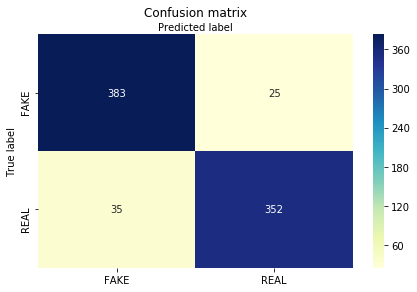

In [11]:
vectorizer = TfidfVectorizer(stop_words='english')
model = PassiveAggressiveClassifier(random_state=seed)

run_full_iteration(prepared_train_df, model, vectorizer,
                   target_var, independent_var, size, seed, cv=4)


# Feature Engineering

## FE1: Combine Title and Text

In [12]:
fe1_train_df = prepared_train_df.copy()
fe1_test_df = prepared_test_df.copy()

fe1_train_df['combined'] = fe1_train_df['title'] + fe1_train_df['text']
fe1_test_df['combined'] = fe1_test_df['title'] + fe1_test_df['text']
fe1_train_df.head()

,ID,title,text,label,X1,X2,combined
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,NaN,NaN,"You Can Smell Hillary’s FearDaniel Greenfield,..."
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,NaN,NaN,Watch The Exact Moment Paul Ryan Committed Pol...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,NaN,NaN,Kerry to go to Paris in gesture of sympathyU.S...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,NaN,NaN,Bernie supporters on Twitter erupt in anger ag...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,NaN,NaN,The Battle of New York: Why This Primary Matte...


Accuracy: 0.930
Mean Accuracy after CV: 0.920 +/- 0.008
Best Accuracy after CV: 0.935


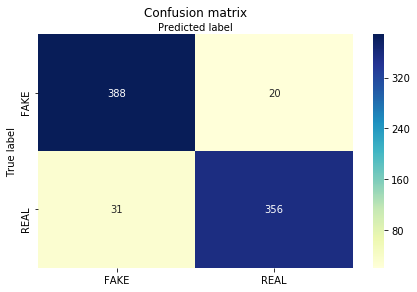

In [13]:
independent_var = 'combined'
run_full_iteration(fe1_train_df, model, vectorizer,
                   target_var, independent_var, size, seed)


# Hyperparameter Tuning

In [14]:
param = {
    'tfidf__max_df': (0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'PAC__C': [0.1, 1, 10]
}

vectorizer_object = ('tfidf', vectorizer)
model_object = ('PAC', model)

tuned_model = tune_model(fe1_train_df, model_object, vectorizer_object, param, target_var, independent_var,
                         seed, cv=4, gridSearch=True)


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 13.0min finished


best params: Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.5, max_features=None, min_df=1,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,...12345, shuffle=True, tol=None,
              validation_fraction=0.1, verbose=0, warm_start=False))])
best params: {'PAC__C': 10, 'tfidf__max_df': 0.5, 'tfidf__ngram_range': (1, 2)}
best score: 0.9209127852453892


Accuracy: 0.912
Mean Accuracy after CV: 0.921 +/- 0.010
Best Accuracy after CV: 0.934


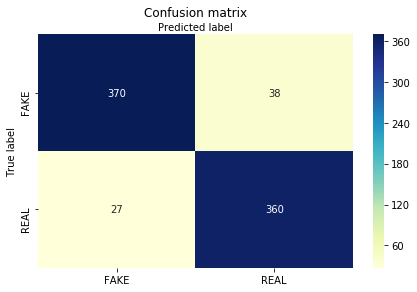

In [17]:
run_full_iteration(fe1_train_df, tuned_model, vectorizer,
                   target_var, independent_var, size, seed, standalone=True)


# Predict on Test Set

In [18]:
final_pred = pd.DataFrame(tuned_model.predict(fe1_test_df['combined']))
final_clean_output = csv_conversion(fe1_test_df, final_pred, 
                                    id_field = 'ID',old_target_name=target_var)

final_clean_output.to_csv("NLP_FAKE_NEWS_PREDICTIONS.csv", index=False)
final_clean_output.head()


,ID,label
0,10498,FAKE
1,2439,REAL
2,864,REAL
3,4128,REAL
4,662,REAL
